# Projek Dicoding
## Belajar Pengembangan Machine Learning
### Time Series


---
##### Nama: Rangga Wibisana Putra Pamungkas
---
Projek Kedua Dicoding dari Belajar Pengembangan Machine Learning adalah membuat sebuah model  yang dapat memprediksi temperature dari data temperature di kota Washington menggunakan Long Short-Term Memory (LSTM) Layer.

# 1. Loading the Dataset

In [1]:
# Menghubungkan Drive dengan Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load dataset sebagai dataframe
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/city_temperature.csv', low_memory=False)

# Melihat sampel teratas dataframe
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [3]:
# Melihat info dari data set dan mengecek nilai null
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

# Data Preprocessing

In [4]:
# Mengimpor paket yang diperlukan
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.layers import Dense, LSTM
from keras.callbacks import ReduceLROnPlateau, Callback

In [5]:
# Mengambil hanya data dari kota Washington
df = df[df["City"] == "Washington"]
df.tail()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1687050,North America,US,District of Columbia,Washington,5,9,2020,45.2
1687051,North America,US,District of Columbia,Washington,5,10,2020,50.2
1687052,North America,US,District of Columbia,Washington,5,11,2020,56.1
1687053,North America,US,District of Columbia,Washington,5,12,2020,52.5
1687054,North America,US,District of Columbia,Washington,5,13,2020,53.4


In [6]:
# Menggabungkan kolom Year-Month-Day menjadi satu kolom Dates
df['Dates'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)

# Menghapus kolom Year-Month-Day sebelumnya
df = df.drop(columns=["Year", "Month", "Day"], errors='ignore')

# Drop the old index
df = df.reset_index(drop=True)
df.tail()

,Region,Country,State,City,AvgTemperature,Dates
18525,North America,US,District of Columbia,Washington,45.2,2020-5-9
18526,North America,US,District of Columbia,Washington,50.2,2020-5-10
18527,North America,US,District of Columbia,Washington,56.1,2020-5-11
18528,North America,US,District of Columbia,Washington,52.5,2020-5-12
18529,North America,US,District of Columbia,Washington,53.4,2020-5-13


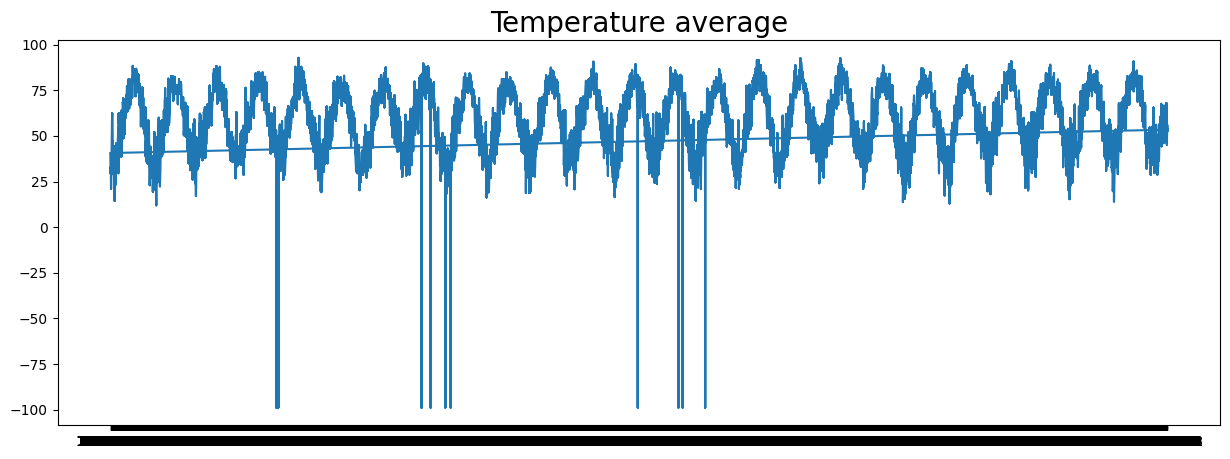

In [7]:
# Menampilkan plot dari data
dates = df['Dates'].values
temp  = df['AvgTemperature'].values


plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

# Encoding Labels and Making Train-Test Splits

In [8]:
# Mengubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Split data menjadi train dan test
dates_train, dates_test, temp_train, temp_test = train_test_split(
    dates, temp, test_size=0.2, shuffle=False)

train_set = windowed_dataset(temp_train, window_size=60,
                             batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60,
                            batch_size=100, shuffle_buffer=1000)

print('train_set: ', len(dates_train))
print('test_set: ', len(dates_test))

train_set:  14824
test_set:  3706


# Building the Model

In [10]:
# model initialization
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

# compile model
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
  loss = tf.keras.losses.Huber(),
  optimizer = optimizer,
  metrics = ['mae'],
)

# Hitung MAE
mae = (df['AvgTemperature'].max() - df['AvgTemperature'].min()) * 0.1
print('MAE: %2.2f' % mae)

MAE: 19.18


In [11]:
# Callback untuk mengurangi learning rate jika tidak ada peningkatan pada mae
reduce_lr = ReduceLROnPlateau(
    monitor="mae",
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001,
)


# Custom callback untuk menghentikan pelatihan jika mae mencapai < 10% skala data
class MyEarlyStop(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get('mae')<mae and logs.get('val_mae')<mae):
            print(
                '\nFor Epoch',
                epoch+1,
                'MAE has reached < 10% of the data scales',
                '\nMAE = %2.2f' % (logs['mae']),
                ', Val MAE = %2.2f' % (logs['val_mae']),
                ', training has been stopped.'
            )
            self.model.stop_training = True

# Model Training and Evaluation

In [12]:
# Pelatihan
history = model.fit(
  train_set,
  epochs=100,
  validation_data = test_set,
  callbacks = [reduce_lr, MyEarlyStop()],
  verbose=1
)

Epoch 1/100
148/148 [==============================] - 31s 180ms/step - loss: 57.3900 - mae: 57.8900 - val_loss: 57.5271 - val_mae: 58.0271 - lr: 1.0000e-04
Epoch 2/100
148/148 [==============================] - 22s 150ms/step - loss: 51.0910 - mae: 51.5910 - val_loss: 39.4083 - val_mae: 39.9077 - lr: 1.0000e-04
Epoch 3/100
148/148 [==============================] - ETA: 0s - loss: 17.6454 - mae: 18.1402
For Epoch 3 \MAE has reached < 10% of the data scales 
MAE = 18.14 , Val MAE = 14.11 , training has been stopped.
148/148 [==============================] - 25s 166ms/step - loss: 17.6454 - mae: 18.1402 - val_loss: 13.6154 - val_mae: 14.1099 - lr: 1.0000e-04


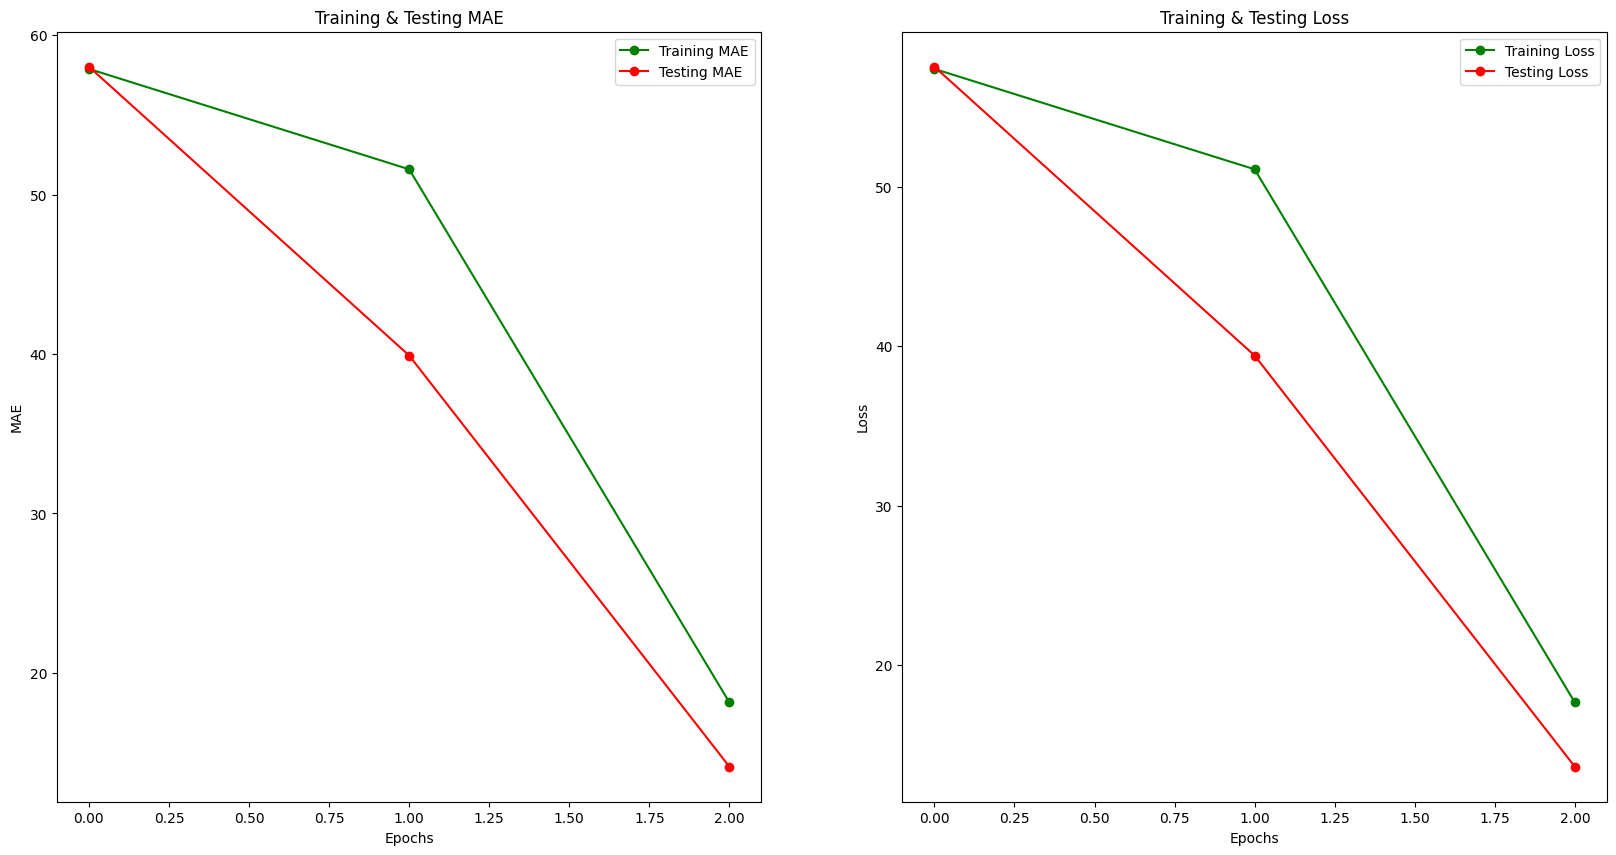

In [13]:
# Menampilkan plot accuracy dan loss
fig, ax = plt.subplots(1,2)
train_mae = history.history['mae']
train_loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy dan loss dari training
ax[0].plot(train_mae , 'go-' , label = 'Training MAE')
ax[0].plot(val_mae , 'ro-' , label = 'Testing MAE')
ax[0].set_title('Training & Testing MAE')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("MAE")

# Plot accuracy dan loss dari testing
ax[1].plot(train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()